In [1]:

# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/IsmaelEA2020/Fisica-computacional/main/Actividad%203/Climatolog%C3%ADa.txt'
url = 'https://raw.githubusercontent.com/IsmaelEA2020/Fisica-computacional/main/Actividad%203/Climatolog%C3%ADa.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3436 entries, 2010-01-01 to 2019-05-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  3436 non-null   float64
 1   Evap    3425 non-null   float64
 2   Tmax    3436 non-null   float64
 3   Tmin    3436 non-null   float64
 4   Año     3436 non-null   int64  
 5   Mes     3436 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 187.9+ KB


In [6]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [7]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2012-01', '2017-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2012-01-01,0.0,4.2,31.0,12.0,2012,Jan
2012-01-02,0.0,5.1,30.0,12.0,2012,Jan
2012-01-03,0.0,4.4,35.0,11.5,2012,Jan
2012-01-04,0.0,5.5,32.5,13.0,2012,Jan
2012-01-05,0.0,4.6,32.0,12.5,2012,Jan


In [8]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2012-01-01    31.0
2012-01-02    30.0
2012-01-03    35.0
2012-01-04    32.5
2012-01-05    32.0
Name: Tmax, dtype: float64

In [9]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()

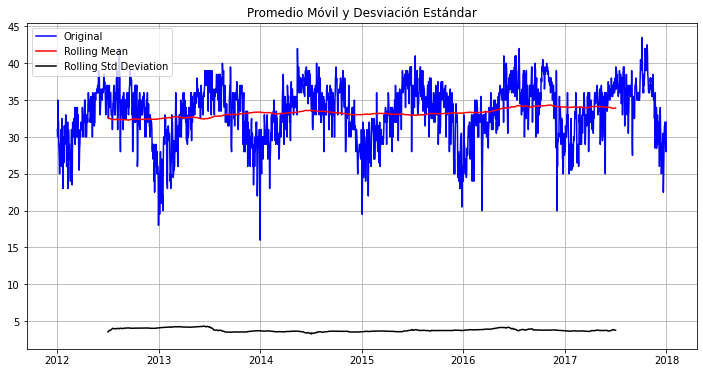

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.902927
p-value                           0.002013
#Lags Used                       14.000000
Number of Observations Used    2175.000000
Critical Value (1%)              -3.433360
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


In [10]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

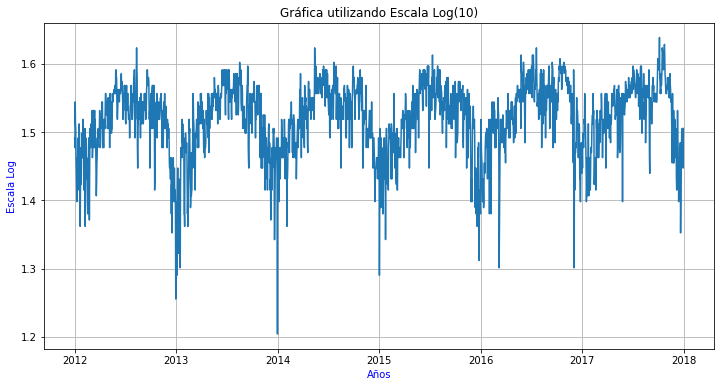

In [11]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


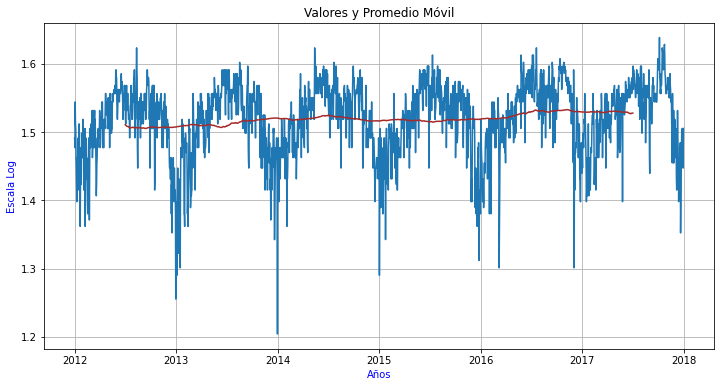

In [12]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [13]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2012-01-01   NaN
2012-01-02   NaN
2012-01-03   NaN
2012-01-04   NaN
2012-01-05   NaN
Name: Tmax, dtype: float64

In [14]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2012-07-01    0.045571
2012-07-02    0.008191
2012-07-03    0.001929
2012-07-04    0.034514
2012-07-05    0.047356
Name: Tmax, dtype: float64

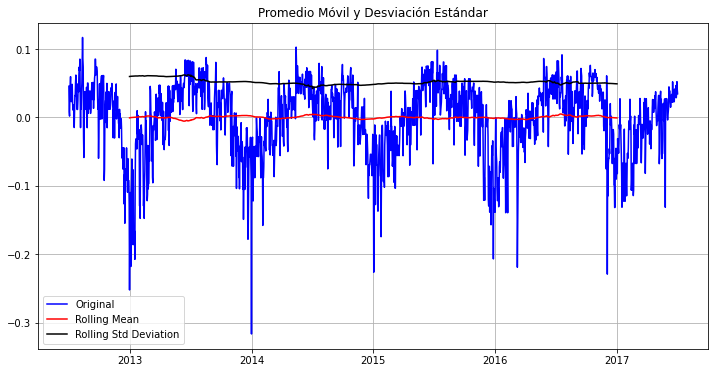

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.650609
p-value                           0.004864
#Lags Used                       14.000000
Number of Observations Used    1811.000000
Critical Value (1%)              -3.433966
Critical Value (5%)              -2.863137
Critical Value (10%)             -2.567620
dtype: float64


In [15]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

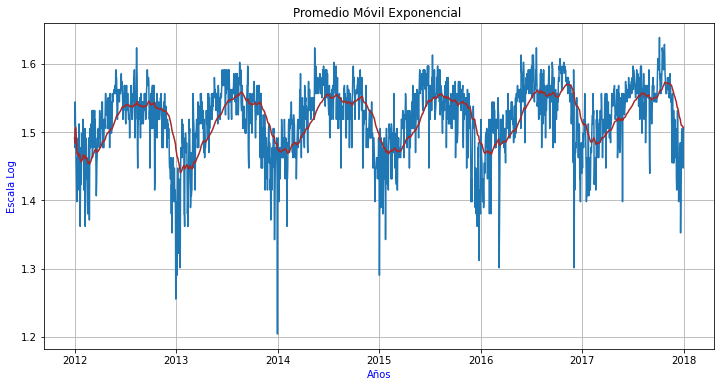

In [16]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [17]:

EWM_avg.head()

Fecha
2012-01-01    1.491362
2012-01-02    1.484159
2012-01-03    1.504592
2012-01-04    1.506478
2012-01-05    1.506200
Name: Tmax, dtype: float64

In [18]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

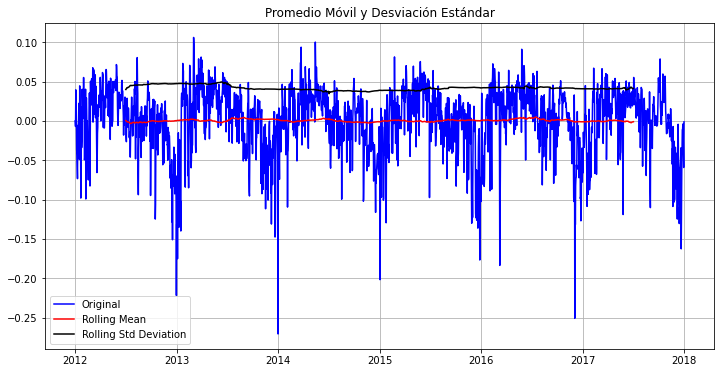

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -5.351549
p-value                           0.000004
#Lags Used                       14.000000
Number of Observations Used    2175.000000
Critical Value (1%)              -3.433360
Critical Value (5%)              -2.862870
Critical Value (10%)             -2.567478
dtype: float64


In [19]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

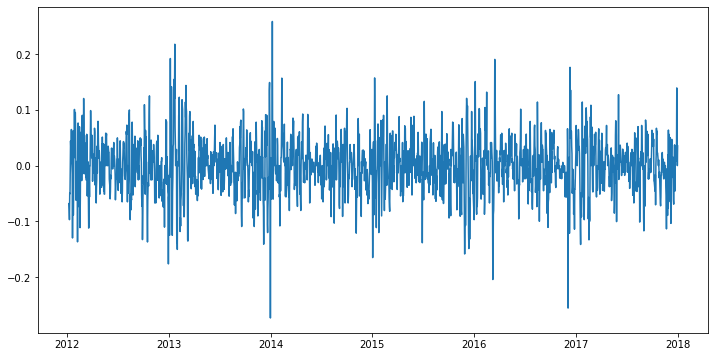

In [20]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

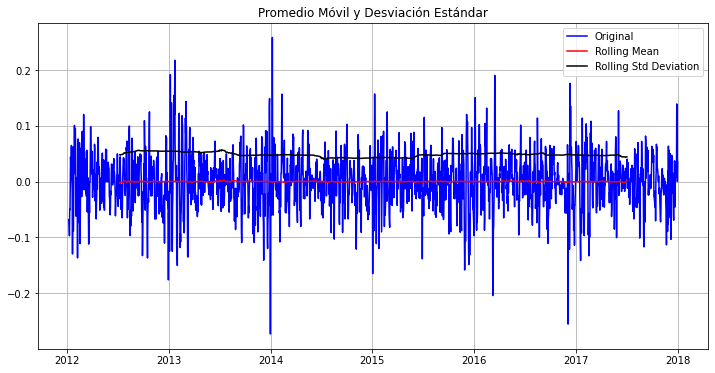

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.454050e+00
p-value                        4.535038e-16
#Lags Used                     2.400000e+01
Number of Observations Used    2.158000e+03
Critical Value (1%)           -3.433384e+00
Critical Value (5%)           -2.862880e+00
Critical Value (10%)          -2.567483e+00
dtype: float64


In [21]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

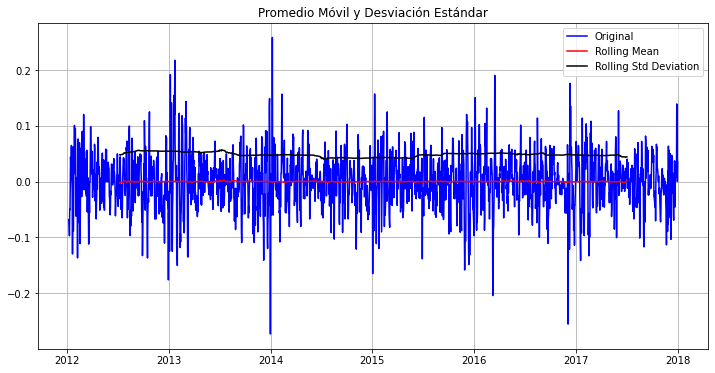

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.454050e+00
p-value                        4.535038e-16
#Lags Used                     2.400000e+01
Number of Observations Used    2.158000e+03
Critical Value (1%)           -3.433384e+00
Critical Value (5%)           -2.862880e+00
Critical Value (10%)          -2.567483e+00
dtype: float64


In [22]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [23]:
# Número de datos utilizados
len(ts_test_log_diff)

2183

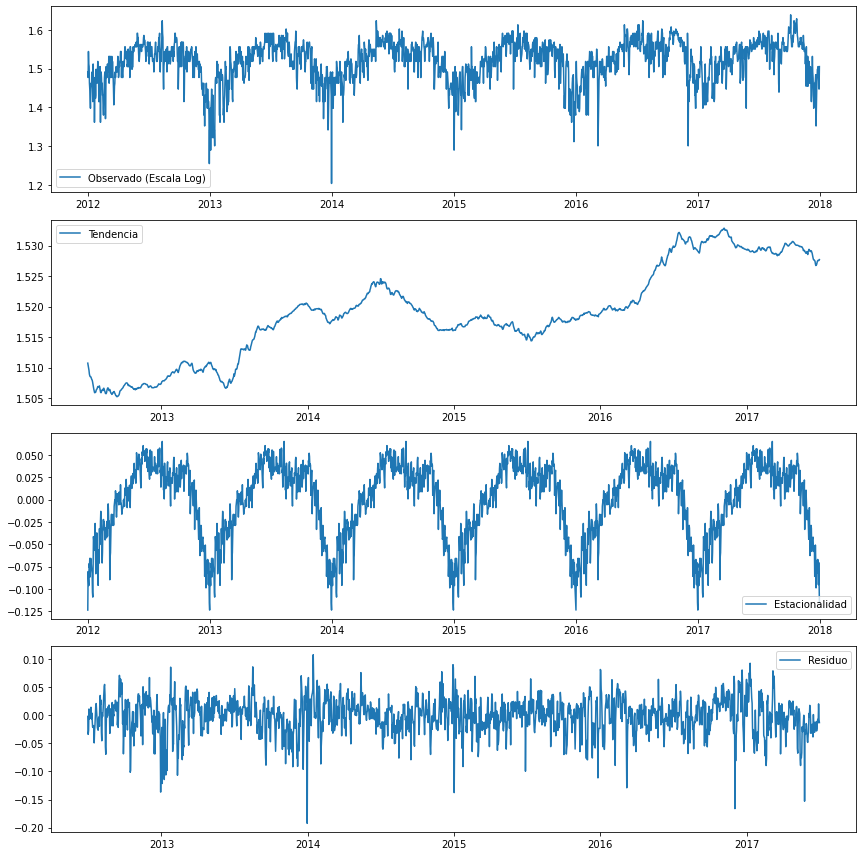

In [24]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

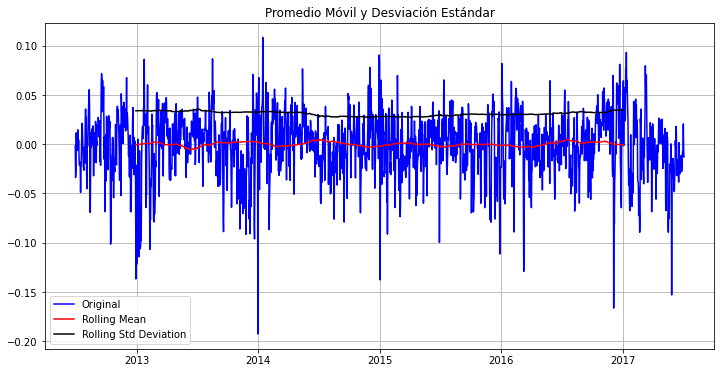

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.566803e+01
p-value                        1.524941e-28
#Lags Used                     3.000000e+00
Number of Observations Used    1.822000e+03
Critical Value (1%)           -3.433944e+00
Critical Value (5%)           -2.863128e+00
Critical Value (10%)          -2.567615e+00
dtype: float64


In [25]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

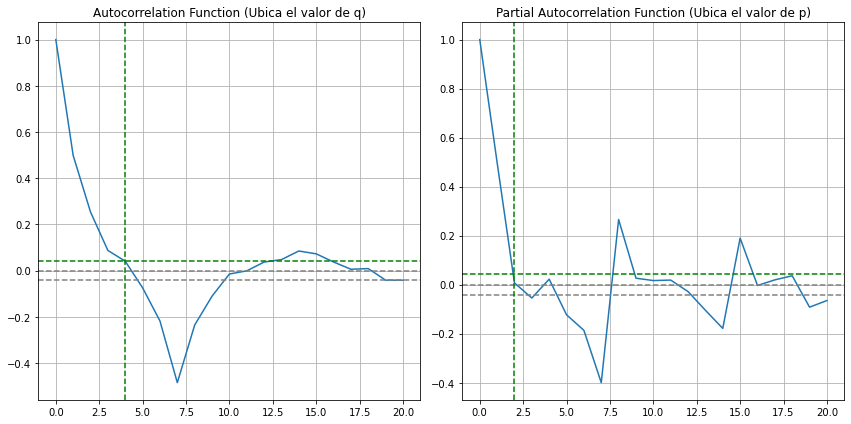

In [26]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(2, 1, 0)   Log Likelihood                4431.485
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 23 Feb 2021   AIC                          -8854.971
Time:                        02:48:51   BIC                          -8832.206
Sample:                             1   HQIC                         -8846.650
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.722e-06      0.000     -0.006      0.995      -0.001       0.001
ar.L1.D.Tmax    -0.3073      0.021    -14.612      0.000      -0.349      -0.266
ar.L2.D.Tmax    -0.1809      0.021     -8.59

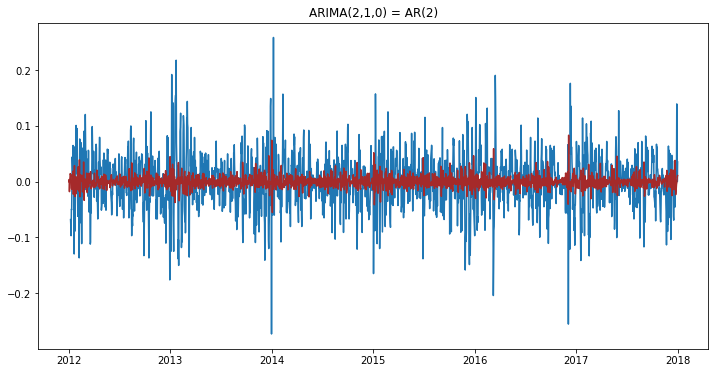

In [28]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(0, 1, 4)   Log Likelihood                4557.977
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 23 Feb 2021   AIC                          -9103.954
Time:                        02:49:04   BIC                          -9069.806
Sample:                             1   HQIC                         -9091.473
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.385e-06      0.000     -0.010      0.992      -0.000       0.000
ma.L1.D.Tmax    -0.4351      0.021    -20.405      0.000      -0.477      -0.393
ma.L2.D.Tmax    -0.1970      0.023     -8.64

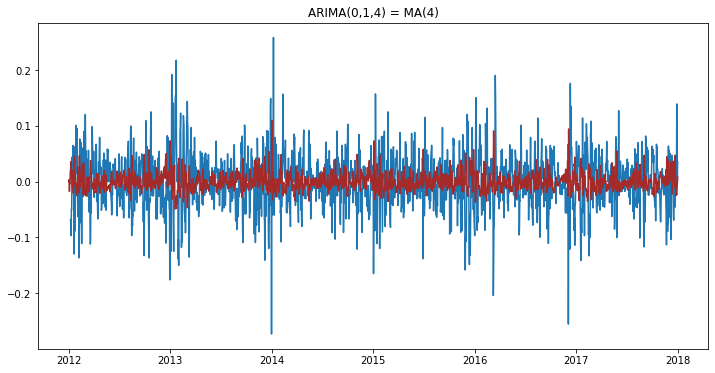

In [29]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 2189
Model:                 ARIMA(2, 1, 4)   Log Likelihood                4560.654
Method:                       css-mle   S.D. of innovations              0.030
Date:                Tue, 23 Feb 2021   AIC                          -9105.307
Time:                        02:49:21   BIC                          -9059.778
Sample:                             1   HQIC                         -9088.666
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1.147e-06      0.000     -0.009      0.993      -0.000       0.000
ar.L1.D.Tmax    -0.7162      0.163     -4.387      0.000      -1.036      -0.396
ar.L2.D.Tmax     0.2477      0.155      1.60

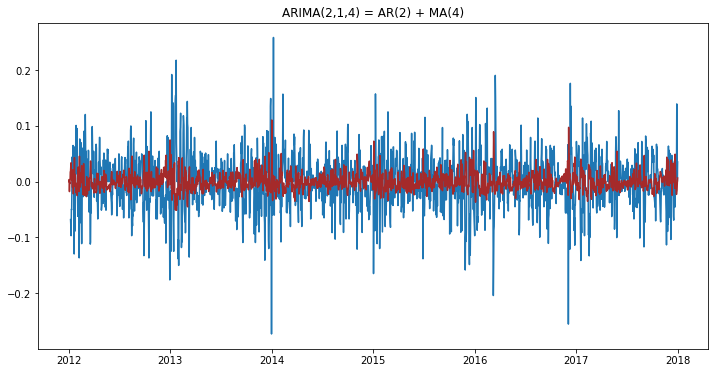

In [30]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [31]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2012-01-02   -0.000001
2012-01-03    0.003685
2012-01-04   -0.017889
2012-01-05   -0.002287
2012-01-06   -0.003393
                ...   
2017-12-27   -0.022933
2017-12-28   -0.019805
2017-12-29   -0.015263
2017-12-30   -0.000668
2017-12-31    0.006420
Length: 2189, dtype: float64


In [32]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2012-01-01         NaN
2012-01-02    1.477120
2012-01-03    1.547753
2012-01-04    1.493994
2012-01-05    1.502863
dtype: float64
Fecha
2017-12-27    1.482217
2017-12-28    1.471557
2017-12-29    1.454559
2017-12-30    1.446490
2017-12-31    1.511570
dtype: float64


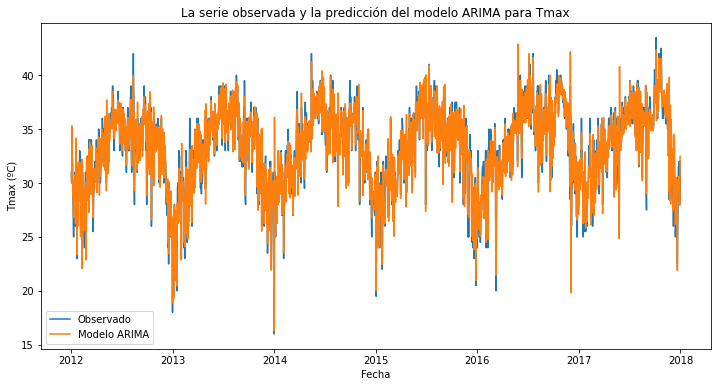

In [33]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

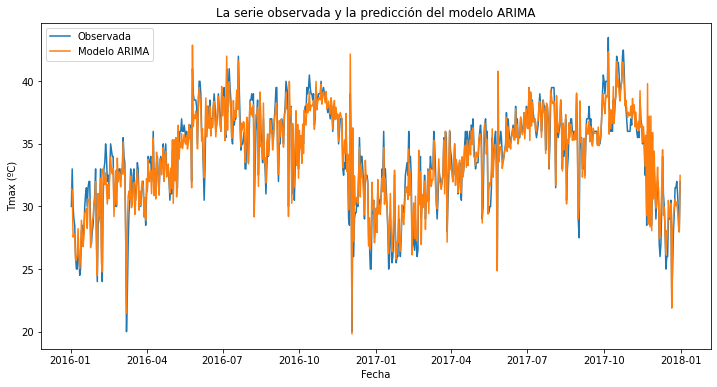

In [34]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');